In [88]:

# coding: utf-8

import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def IrisLocalization(images):
    #convert image to a color image
    target = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    boundary=[] #initialize empty list that will eventually contain all the images with boundaries
    centers=[] #initialize empty list that will contain the centers of the boundary circles
    for img in target:
        
        draw_img=img
        
        # remove noise by blurring the image
        blur = cv2.bilateralFilter(img, 9,75,75)
        img=blur
        
        #estimate the center of pupil
        horizontalProjection = np.mean(img,0);
        verticalProjection = np.mean(img,1);
        center_x=horizontalProjection.argmin()
        center_y=verticalProjection.argmin()
        
        #recalculate of pupil by concentrating on a 120X120 area
        centrecrop_x = img[center_x-60:center_x+60]
        centrecrop_y = img[center_y-60:center_y+60]
        horizontalProjection = np.mean(centrecrop_y,0);
        verticalProjection = np.mean(centrecrop_x,0);
        crop_center_x=horizontalProjection.argmin()
        crop_center_y=verticalProjection.argmin()

        cimg=img.copy()
        cv2.circle(cimg,(crop_center_x,crop_center_y),1,(255,0,0),2)

        #apply Canny edge detector on the masked image
        maskimage = cv2.inRange(img, 0, 70)
        output = cv2.bitwise_and(img, maskimage)
        edged = cv2.Canny(output, 100, 220)
        
        # Apply Hough transform to find potential boundaries of pupil
        circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 10, 100)
        
        #define the center of the pupil
        a = (crop_center_x,crop_center_y)
        
        out = img.copy()
        min_dst=math.inf
        for i in circles[0]:
            #find the circle whose center is closest to the approx center found above
            b=(i[0],i[1])
            dst = distance.euclidean(a, b)
            if dst<min_dst:
                min_dst=dst
                k=i
                
        #draw the inner boundary
        cv2.circle(draw_img,  (int(k[0]), int(k[1])), int(k[2]), (255, 0, 0), 3)

        pupil=circles[0][0]
        radius_pupil = int(k[2])
        
        #draw the outer boundary, which is approximately found to be at a distance 53 from the inner boundary 
        cv2.circle(draw_img,  (int(k[0]), int(k[1])), int(radius_pupil+53), (255, 0, 0), 3)
        boundary.append(draw_img)
        centers.append([k[0],k[1],k[2]])
    return boundary,centers


In [89]:

# coding: utf-8
import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def IrisNormalization(boundary,centers):
    target = [img for img in boundary]
    normalized=[]
    cent=0
    for img in target:
        #load pupil centers and radius of inner circles
        center_x = centers[cent][0]
        center_y = centers[cent][1]
        radius_pupil=int(centers[cent][2])
        
        iris_radius = 53 # width of space between inner and outer boundary
    
        #define equally spaced interval to iterate over
        nsamples = 360
        samples = np.linspace(0,2*np.pi, nsamples)[:-1]
        polar = np.zeros((iris_radius, nsamples))
        for r in range(iris_radius):
            for theta in samples:
                #get x and y for values on inner boundary
                x = (r+radius_pupil)*np.cos(theta)+center_x
                y = (r+radius_pupil)*np.sin(theta)+center_y
                x=int(x)
                y=int(y)
                try:
                #convert coordinates
                    polar[r][int((theta*nsamples)/(2*np.pi))] = img[y][x]
                except IndexError: #ignores values which lie out of bounds
                    pass
                continue
        res = cv2.resize(polar,(512,64))
        normalized.append(res)
        cent+=1
    return normalized #returns a list of 64x512 normalized images

In [90]:

# coding: utf-8

import cv2
import numpy as np
import glob
import math
from scipy.spatial import distance
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

#Equalizes the histogram of the image
def ImageEnhancement(normalized):
    enhanced=[]
    for res in normalized:
        res = res.astype(np.uint8)
        im=cv2.equalizeHist(res)
        enhanced.append(im)
    return enhanced


In [91]:
import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


#modulating function as defined in paper
def m(x ,y, f):
    val = np.cos(2*np.pi*f*math.sqrt(x **2 + y**2))
    return val
#spatial filter as defined in paper
def gabor(x, y, dx, dy, f):
    gb = (1/(2*math.pi*dx*dy))*np.exp(-0.5*(x**2 / dx**2 + y**2 / dy**2)) * m(x, y, f)
    return gb

#function to calculate spatial filter over 8x8 blocks
def spatial(f,dx,dy):
    sfilter=np.zeros((8,8))
    for i in range(8):
        for j in range(8):
            sfilter[i,j]=gabor((-4+j),(-4+i),dx,dy,f)
    return sfilter

def get_vec(convolvedtrain1,convolvedtrain2):
    feature_vec=[]
    for i in range(6):
            for j in range(64):
                #Run 8 by 8 filtered block iteratively over the entire image
                start_height = i*8
                end_height = start_height+8
                start_wid = j*8
                end_wid = start_wid+8
                grid1 = convolvedtrain1[start_height:end_height, start_wid:end_wid]
                grid2 = convolvedtrain2[start_height:end_height, start_wid:end_wid]

                # Channel 1
                absolute = np.absolute(grid1)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

                # Channel 2
                absolute = np.absolute(grid2)
                # mean
                mean = np.mean(absolute)
                feature_vec.append(mean)
                #deviation
                std = np.mean(np.absolute(absolute-mean))
                feature_vec.append(std)

    return feature_vec

def FeatureExtraction(enhanced):
    con1=[]
    con2=[]
    #get spatial filters
    filter1=spatial(0.67,3,1.5)
    filter2=spatial(0.67,4,1.5) 
    
    feature_vector=[]
    
    for i in range(len(enhanced)):
        img=enhanced[i]
        #define a 48x512 region over which the filters are applied
        img_roi=img[:48,:]
        
        filtered1=scipy.signal.convolve2d(img_roi,filter1,mode='same')
        filtered2=scipy.signal.convolve2d(img_roi,filter2,mode='same')
        
        con1.append(filtered1)
        con2.append(filtered2)
        fv=get_vec(filtered1,filtered2)
        feature_vector.append(fv)
    return feature_vector #each feature vector has a dimension of 1536

In [92]:
from math import *
from decimal import Decimal
from scipy.spatial import distance

def nth_root(value, n_root):
 
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
def square_rooted(x):
 
    return round(sqrt(sum([a*a for a in x])),3)

def IrisMatching(feature_vector_train,feature_vector_test):
    eu_dist=[]
    mh_dist=[]
    mk_dist=[]
    cos_dist=[]
    can_dist=[]
    for test in feature_vector_test:
        y=test
        for train in feature_vector_train:
            x=train
            #print(len(x))
            eu_dist.append(sqrt(sum(pow(a-b,2) for a, b in zip(x, y))))
            mh_dist.append(sum(abs(a-b) for a,b in zip(x,y)))
            mk_dist.append(nth_root(sum(pow(abs(a-b),3) for a,b in zip(x, y)),3))
            numerator = sum(a*b for a,b in zip(x,y))
            denominator = square_rooted(x)*square_rooted(y)
            cos_dist.append(round(numerator/float(denominator),3))
            can_dist.append(distance.canberra(x,y))
    return eu_dist,mh_dist,mk_dist,cos_dist,can_dist

In [100]:
def PerformanceEvaluation(means,threshold):
    print(t)
    arr=[]
    for i in range(9):
        l=[]
        for j in range(9):
            if means[i][j] >= t:
                l.append(1)
            else:
                l.append(0)
        arr.append(l)
    print(arr)
    
    c,crr_cosine,wrong_rej=0,0,0
    for a in arr:
        c+=a.count(1)
    #print("c= ",c)
    crr_cosine=9/c
    
    fmr=(c-9)/c
    
    for i in range(9):
        for j in range(9):
            if i==j and arr[i][j]==0:
                wrong_rej+=1

    fnmr=wrong_rej/(81-c)
    
    #print(arr)
    return crr_cosine*100,fmr,fnmr
    

0.965
[[1, 0, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 1, 1], [0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 1]]
0.968
[[1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1]]
0.969
[[1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1]]
0.97
[[1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 

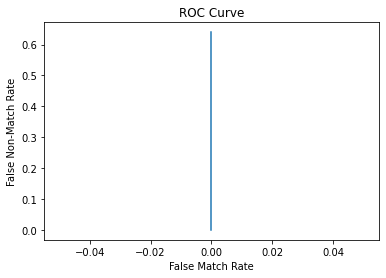

In [105]:
# coding: utf-8

import cv2
import numpy as np
import glob
import math
import scipy
from scipy.spatial import distance
from statistics import mean
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

'''TRAINING
#reading the training images from the CASIA dataset
#find cust id fir pass ./custid/1/*.bmp
images_train = [cv2.imread(file) for file in sorted(glob.glob('D:/College/BE project/Dataset/Iris final dataset/007/1/*.bmp'))]

#running Localization, Normalization,Enhancement and Feature Extraction on all the training images
boundary_train,centers_train=IrisLocalization(images_train)
normalized_train=IrisNormalization(boundary_train,centers_train)
enhanced_train=ImageEnhancement(normalized_train)
feature_vector_train=FeatureExtraction(enhanced_train)
print("Training data processed.")


#TESTING
#reading the testing images from the CASIA dataset
#take path from user(atm se)  ./custid/2custid_2_2.bmp
images_test = [cv2.imread(file) for file in sorted(glob.glob('D:/College/BE project/Dataset/Iris final dataset/001/2/001_2_3.bmp'))]
#running Localization, Normalization,Enhancement and Feature Extraction on all the testing images
boundary_test,centers_test=IrisLocalization(images_test)
normalized_test=IrisNormalization(boundary_test,centers_test)
enhanced_test=ImageEnhancement(normalized_test)
feature_vector_test=FeatureExtraction(enhanced_test)
print("Testing data processed.")

eu_dist,mh_dist,mk_dist,cos_dist,can_dist=IrisMatching(feature_vector_train,feature_vector_test)
print(cos_dist)
print("mean - ",mean(cos_dist))
if mean(cos_dist) >= 0.965:
    print("Fingerprint matched")
else:
    print("Fingerprint does't match") 
    
    
if mean(cos_dist) >= 0.968:
            l.append("1 ")
        else:
            l.append("0 ")
'''
means=[]
for i in range(9):
    l=[]
    for j in range(9):
        path="D:/College/BE project/Dataset/Iris final dataset - Copy/"
        no1='{0:03d}'.format(i+1)
        no2='{0:03d}'.format(j+1)
        p1="/1/*.bmp"
        p2="/2/*.bmp"
        
        images_train = [cv2.imread(file) for file in sorted(glob.glob(path+no2+p1))]

        #running Localization, Normalization,Enhancement and Feature Extraction on all the training images
        boundary_train,centers_train=IrisLocalization(images_train)
        normalized_train=IrisNormalization(boundary_train,centers_train)
        enhanced_train=ImageEnhancement(normalized_train)
        feature_vector_train=FeatureExtraction(enhanced_train)
        #print("Training data processed.")

        images_test = [cv2.imread(file) for file in sorted(glob.glob(path+no1+p2))]
        #running Localization, Normalization,Enhancement and Feature Extraction on all the testing images
        boundary_test,centers_test=IrisLocalization(images_test)
        normalized_test=IrisNormalization(boundary_test,centers_test)
        enhanced_test=ImageEnhancement(normalized_test)
        feature_vector_test=FeatureExtraction(enhanced_test)
        #print("Testing data processed.")

        eu_dist,mh_dist,mk_dist,cos_dist,can_dist=IrisMatching(feature_vector_train,feature_vector_test)
        #print(cos_dist)
        #print("mean - ",mean(cos_dist))
        l.append(mean(cos_dist))
        
    means.append(l)
#print(means)
threshold=[0.965,0.968,0.969,0.97]
crr_cosine_all,fmr_all,fnmr_all=[],[],[]
for t in threshold:
    crr_cosine,fmr,fnmr=PerformanceEvaluation(means,t)
    crr_cosine_all.append(crr_cosine)
    fmr_all.append(fmr)
    fnmr_all.append(fnmr)
print("Performance evaluation")
dict1={'Threshold':threshold,'CRR cosine':crr_cosine_all,'FMR':fmr_all,'FNMR':fnmr_all}
roc_table=pd.DataFrame(dict1)
print("ROC Measures : \n")
print(roc_table.iloc[0],"\n")
print(roc_table.iloc[1],"\n")
print(roc_table.iloc[2],"\n")
print(roc_table.iloc[3])

#Plotting the ROC Curve
plt.plot(fnmr_all,fmr_all)
plt.title('ROC Curve')
plt.ylabel('False Non-Match Rate')
plt.xlabel('False Match Rate')
plt.show()